In [155]:
# Import packages
%matplotlib inline
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import psycopg2
from sqlalchemy import create_engine

In [39]:
#Import data
df_trees = pd.read_csv('Data/Intermediate/model_data.csv',index_col='tree_id')

In [48]:
# Import impervious surface and building height data generated in QGIS
df_imp_bldghght = pd.read_csv('Data/spatialdatasets/data_with_imp_bldghght.csv',index_col='tree_id')

In [49]:
# drop un-needed columns
df_imp_bldghght.drop(['address','block_id', 'created_at', 'curb_loc', 'guards', 'health',
       'latitude', 'longitude', 'problems', 'root_grate', 'root_other',
       'root_stone', 'sidewalk', 'spc_common', 'status', 'steward', 'tree_dbh',
       'trnk_light', 'trnk_other', 'trnk_wire', 'zipcode'],axis=1,inplace=True)

In [50]:
# merge tree data and spatial data
df = df_trees.merge(df_imp_bldghght,how='left',left_index=True,right_index=True)

In [51]:
# Rename confusing columns and drop un-needed ones
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.rename(columns={'rvalue_1':'impervious_pct'},inplace=True)
df.drop('Incident Zip',axis=1,inplace=True)
df.rename(columns={'Descriptor':'Fall'},inplace=True)

In [52]:
# Deal with categorical data
# make a copy
dt_input = df.copy()

# First convert all Yes/No and True/False columns to 1/0
dt_input.replace({'No': 0, 'Yes': 1},value=None,inplace=True)
dt_input.replace({False: 0, True: 1},value=None,inplace=True)
dt_input.replace(np.nan,0,inplace=True)

# Now convert all 2 option columns to 1/0
dt_input.curb_loc.replace({'OnCurb':1, 'OffsetFromCurb':0},value=None,inplace=True)
dt_input.sidewalk.replace({'Damage':1, 'NoDamage':0},value=None,inplace=True)
dt_input.Fall.replace('Branch or Limb Has Fallen Down',1,inplace=True)

# Replace health, steward, and guards columns with numerical levels
dt_input.health.replace({'Poor':0,'Fair':1,'Good':2},value=None,inplace=True)
dt_input.steward.replace({'None':0,'1or2':1,'3or4':2,'4orMore':3},value=None,inplace=True)
dt_input.guards.replace({'Harmful':0,'None':1,'Unsure':2,'Helpful':4},value=None,inplace=True)

# Target encode tree species descriptor data
# First split train and test data to prevent data leakage
dt_train, dt_test = train_test_split(dt_input, random_state=1,test_size=0.8) # small train size for grid search efficiency

target_dict = dt_train.groupby('spc_common')['Fall'].mean()
dt_train['spc_common'] = dt_train['spc_common'].map(target_dict)
dt_test['spc_common'] = dt_test['spc_common'].map(target_dict)


C:\Users\Brianne\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Brianne\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
# Use gridsearch to optimize parameters
x_train = dt_train.drop(['zipcode','Fall','address'],axis=1)
y_train = dt_train.Fall
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#model
forest = RandomForestClassifier(random_state = 1)

# Grid Search
n_estimators = [100, 300]
max_depth = [10, 30, 50]
class_weight = ['balanced', 'balanced_subsample', None]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth, class_weight=class_weight)

gridF = GridSearchCV(forest, hyperF, scoring = 'recall', n_jobs = -1)

C:\Users\Brianne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [17]:
# Check gridsearch scores
gridF.cv_results_['mean_test_score']

array([0.74340704, 0.74411981, 0.18650512, 0.18507961, 0.15419336,
       0.15538128, 0.74530772, 0.74602049, 0.18127826, 0.18151583,
       0.15561889, 0.15633162, 0.02328342, 0.023521  , 0.15039201,
       0.1506296 , 0.1620337 , 0.16250887])

In [19]:
# check gridsearch optimized parameters
gridF.best_params_

{'class_weight': 'balanced_subsample', 'max_depth': 10, 'n_estimators': 300}

In [23]:
# check gridsearch AUC
x_test = dt_test.drop(['zipcode','Fall','address'],axis=1)
y_test = dt_test.Fall
y_pred = gridF.predict(x_test)
roc_auc_score(y_test,y_pred)

0.7818494913885068

In [24]:
# check gridsearch confusion matrix
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall']
)

,Predicted No Fall,Predicted Fall
True No Fall,497372,115624
True Fall,4110,12484


C:\Users\Brianne\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Brianne\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Feature ranking:
1. feature heightroof (0.355961)
2. feature Branch Cracked and Will Fall (0.175371)
3. feature tree_dbh (0.122930)
4. feature spc_common (0.090125)
5. feature Hitting Building (0.058071)
6. feature Dead Branches in Tree (0.056429)
7. feature Blocking Street (0.032773)
8. feature Hitting Power/Phone Lines (0.026240)
9. feature Tree Leaning/Uprooted (0.022557)
10. feature Tree Alive - in Poor Condition (0.014256)
11. feature impervious_pct (0.010377)
12. feature guards (0.006857)
13. feature root_stone (0.006377)
14. feature health (0.005870)
15. feature sidewalk (0.005302)
16. feature curb_loc (0.005041)
17. feature steward (0.002817)
18. feature root_other (0.000896)
19. feature trnk_other (0.000810)
20. feature trnk_wire (0.000582)
21. feature root_grate (0.000231)
22. feature trnk_light (0.000127)


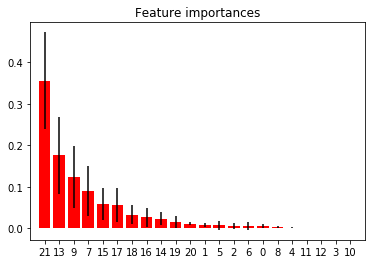

In [97]:
# Fit a random forest to the data and check feature importance
dt_train, dt_test = train_test_split(dt_input, random_state=1,test_size=0.2)
dt_train2 = dt_train.copy()
dt_test2 = dt_test.copy()
dt_train['spc_common'] = dt_train['spc_common'].map(target_dict)
dt_test['spc_common'] = dt_test['spc_common'].map(target_dict)

x_train = dt_train.drop(['zipcode','Fall','address'],axis=1)
y_train = dt_train.Fall

forest = RandomForestClassifier(n_jobs=-1,class_weight='balanced_subsample',random_state = 1, max_depth = 10, n_estimators = 300)

model = forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, x_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [98]:
# Check AUC for model on test data
x_test = dt_test.drop(['zipcode','Fall','address'],axis=1)
y_test = dt_test.Fall
y_pred = forest.predict(x_test)
roc_auc_score(y_test,y_pred)

0.790570840634056

In [99]:
# Check confusion matrix for model on test data
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall']
)

,Predicted No Fall,Predicted Fall
True No Fall,123861,29425
True Fall,933,3179


In [245]:
accuracy_score(y_test,y_pred)

0.8071258846999326

In [100]:
# Calculate Fall probabilities of each tree from model
prob_train = forest.predict_proba(x_train)
prob_test = forest.predict_proba(x_test)

In [130]:
# combine all fall probabilites with data
dt_train2['fallprob'] = prob_train[:,1]
dt_test2['fallprob'] = prob_test[:,1]
data_prob = dt_train2.append(dt_test2)

In [254]:
# Remove duplicate trees
data_prob.reset_index(inplace=True)
data_prob.drop_duplicates(subset='tree_id',inplace=True)

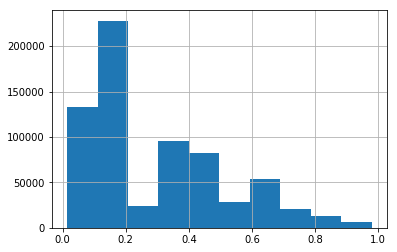

In [255]:
# plot
data_prob.fallprob.hist()

In [256]:
# clean up dataset
data_prob.drop(['Fall','Branch Cracked and Will Fall', 'Tree Leaning/Uprooted',
       'Hitting Building', 'Hitting Power/Phone Lines',
       'Dead Branches in Tree', 'Blocking Street',
       'Tree Alive - in Poor Condition'],axis=1,inplace=True)
data_prob.columns

KeyError: "['Fall' 'Branch Cracked and Will Fall' 'Tree Leaning/Uprooted'\n 'Hitting Building' 'Hitting Power/Phone Lines' 'Dead Branches in Tree'\n 'Blocking Street' 'Tree Alive - in Poor Condition'] not found in axis"

In [257]:
# export data
data_prob.to_csv('Data/ModelData/WarnModelOutput.csv')

In [258]:
# import no warn model data to merge model outputs
nw_data_prob = pd.read_csv('Data/ModelData/NoWarnModelOutput.csv')

In [259]:
# import fall/warning ratios
warn_fall_ratio_data = geopandas.read_file('Data/spatialdatasets/Fall_Count.shp')

In [260]:
# grab only zipcode and warnings per fall data
warn_fall_ratio = fall_warn_ratio_data[['ZIPCODE','DamperFall']]

In [261]:
# Find max warn per fall ratio for normalization use 2nd largest warn per fall ratio because max is so big
max_warn_fall_ratio = warn_fall_ratio['DamperFall'].nlargest(n=2).iloc[1]
warn_fall_ratio.loc[16,'DamperFall'] = max_warn_fall_ratio

In [262]:
#Create final merged model fall probabilities
model_ratio =pd.DataFrame()
model_ratio['zipcode'] = warn_fall_ratio['ZIPCODE']
model_ratio['ratio'] = warn_fall_ratio['DamperFall']/max_warn_fall_ratio

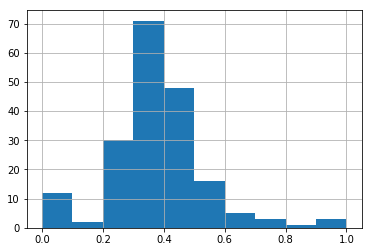

In [263]:
# check that the ratios look reasonable
model_ratio['ratio'].hist()

In [264]:
# update zipcode type so merge works
model_ratio['zipcode'] = model_ratio.zipcode.astype(int)

In [265]:
# Join ratios to dataset
data_prob = data_prob.merge(model_ratio,how='left',right_on='zipcode',left_on='zipcode')

In [266]:
# Make a merged prediction for each tree
final_fall_prob = data_prob.fallprob*data_prob.ratio + nw_data_prob.fallprob * (1-data_prob.ratio)

AttributeError: 'DataFrame' object has no attribute 'ratio'

In [ ]:
final_fall_prob.hist()

In [143]:
# create the final output table to send to SQL
final_table = data_prob.copy()
final_table.drop(['ratio','fallprob'],axis=1,inplace=True)
final_table['fallprob'] = final_fall_prob

In [150]:
# round long decimals
final_table.heightroof=final_table.heightroof.astype(int)
final_table.fallprob = final_table.fallprob.round(decimals=2)
final_table.tree_id = final_table.tree_id.astype(int)

In [208]:
# drop any rows where fallprob is nan
final_table = final_table[pd.notnull(final_table['fallprob'])]

In [209]:
# save to csv
final_table.to_csv('Data/FinalOutputs/final_table.csv')

In [210]:
# copy data to AWS RDS postgreSQL database
# Import postgres connection info
import PostgresAWScodes

con = None
con = psycopg2.connect(password=pwd, port=port,user=user,host=host)
cursor = con.cursor()

with open(r'Data/FinalOutputs/final_table.csv', 'r') as row:
    next(row)
    cursor.copy_from(row, 'finaltable', sep=',')
    
con.commit() 

In [217]:
# Make dataset of trees > 0.75 fall probability for the map
high_risk_trees = final_table[final_table['fallprob']>=0.75]
high_risk_zips=high_risk_trees.groupby('zipcode').count().tree_id
high_risk_zips.to_csv('Data/FinalOutputs/high_risk_zips.csv',index=True)

In [226]:
# join lat lon to final table to output tree maps with fall probabilities
df_imp_bldghght = pd.read_csv('data_with_imp_bldghght.csv',index_col='tree_id')
df_imp_bldghght.drop(['rvalue_1', 'heightroof','address','block_id', 'created_at', 'curb_loc', 'guards', 'health',
       'problems', 'root_grate', 'root_other',''
       'root_stone', 'sidewalk', 'spc_common', 'status', 'steward', 'tree_dbh',
       'trnk_light', 'trnk_other', 'trnk_wire', 'zipcode'],axis=1,inplace=True)
df_imp_bldghght.reset_index(inplace=True)

In [231]:
# merge final table and lat lon data
map_table = final_table.merge(df_imp_bldghght,how='inner',left_on='tree_id',right_on='tree_id')
map_table.drop_duplicates(inplace=True)

In [244]:
# export 
map_table.to_csv('Data/FinalOutputs/map_table.csv')

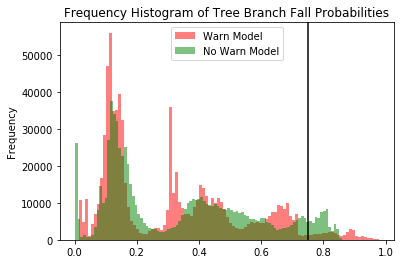

In [249]:
# Create a histogram of the distributions of all probability for different models
x1 = data_prob.fallprob
x2 = nw_data_prob.fallprob

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='r', label='Warn Model')
plt.hist(x2, **kwargs, color='g', label='No Warn Model')
plt.gca().set(title='Frequency Histogram of Tree Branch Fall Probabilities', ylabel='Frequency')
#plt.xlim(50,75)
plt.axvline(x=.75,color='k')
plt.legend();

In [252]:
# Check counts of trees with fall prb > .75 in two models
nw_data_prob[nw_data_prob.fallprob>0.75].tree_id.count()-data_prob[data_prob.fallprob>0.75].tree_id.count()


26848